# Step 1: Import Libraries

In [1]:
import numpy as np
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage import io
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Step 2: Load and Preprocess Images

In [2]:
# Load and preprocess images consistently
data = []
label = []
image_paths = glob.glob('./train/*/*.jpg')  # Adjust this path to where your images are stored

for image_path in tqdm(image_paths, desc="Processing Images"):
    image = io.imread(image_path)
    img_gray = rgb2gray(image)
    img_resized = resize(img_gray, (128, 128), anti_aliasing=True)
    img_normalized = img_resized / 255.0  # Normalize before flattening
    img_flattened = img_normalized.flatten()
    data.append(img_flattened)
    label.append(1 if 'cat' in image_path else 0)

# Convert lists to NumPy arrays for easier handling
data = np.array(data)
label = np.array(label)
print(f"Data shape: {data.shape}, Label shape: {label.shape}")

Processing Images: 100%|██████████████████████████████████████████████████████████| 3862/3862 [00:22<00:00, 170.61it/s]


Data shape: (3862, 16384), Label shape: (3862,)


In [3]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=42)
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

Training set shape: (2703, 16384), Testing set shape: (1159, 16384)


# Step 3: Train and Evaluate

In [4]:
# Initialize and train the SVM Classifier
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)
print("Model training completed!")

# Evaluate the SVM Classifier
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Model training completed!
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.01      0.02       551
           1       0.52      0.97      0.68       608

    accuracy                           0.52      1159
   macro avg       0.40      0.49      0.35      1159
weighted avg       0.40      0.52      0.37      1159

Confusion Matrix:
[[  6 545]
 [ 16 592]]


# Step 4: Prepare Data for CNN Classifier

In [5]:
# Reshape data for CNN (Add a channel dimension)
X_cnn = data.reshape(-1, 128, 128, 1)  # Add a channel dimension for grayscale images
y_cnn = label  # For binary classification, we keep labels as-is

# Split data for CNN training and testing
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cnn, test_size=0.3, random_state=42)

# Step 5: Define and Train the CNN Classifier

Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.5124 - loss: 0.6931 - val_accuracy: 0.5246 - val_loss: 0.6929
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.5366 - loss: 0.6926 - val_accuracy: 0.5246 - val_loss: 0.6927
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.5184 - loss: 0.6927 - val_accuracy: 0.5246 - val_loss: 0.6923
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.5128 - loss: 0.6927 - val_accuracy: 0.5246 - val_loss: 0.6922
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.5229 - loss: 0.6923 - val_accuracy: 0.5246 - val_loss: 0.6922
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.5054 - loss: 0.6935 - val_accuracy: 0.5246 - val_loss: 0.6922
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.5257 - loss: 0.6917 - val_accuracy: 0.5246 - val_loss: 0.6922
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.5246 - loss: 0.6924 - val_accura

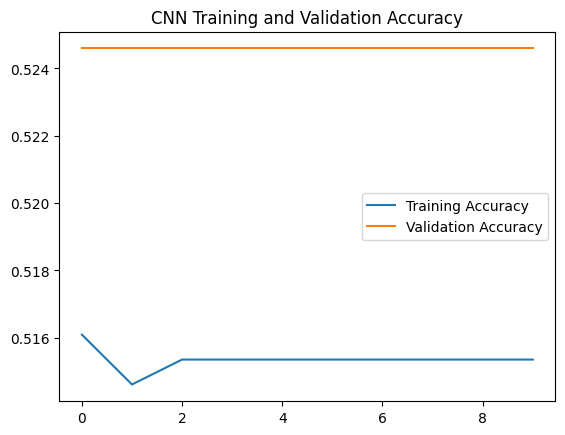

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Define the CNN architecture with an Input layer
cnn_model = Sequential([
    Input(shape=(128, 128, 1)),  # Explicitly define the input shape here
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the CNN model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
history = cnn_model.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=10, batch_size=32)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.legend()
plt.show()


# Step 6: Predict Using the CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


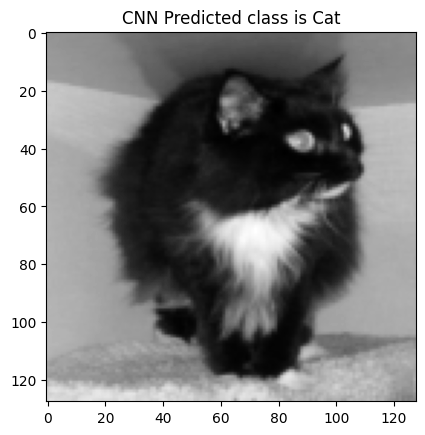

In [8]:
# Process an individual image to use for prediction
def process_image(image_path):
    img = io.imread(image_path)
    img_gray = rgb2gray(img)
    img_resized = resize(img_gray, (128, 128), anti_aliasing=True)
    img_normalized = img_resized / 255.0
    img_flattened = img_normalized.flatten()
    return img_normalized.reshape(1, 128, 128, 1)  # Reshape for CNN input

# Use the CNN model to predict a new image
image_path = './train/cat/cat.2100.jpg'  # Adjust this path for your test image
processed_image_cnn = process_image(image_path)
predicted_cnn = cnn_model.predict(processed_image_cnn)
predicted_class_cnn = 'Cat' if predicted_cnn[0] > 0.5 else 'Dog'

# Display the image and prediction result
plt.imshow(processed_image_cnn[0].reshape(128, 128), cmap='gray')
plt.title(f'CNN Predicted class is {predicted_class_cnn}')
plt.show()

# Step 7: Compare CNN and SVM Predictions

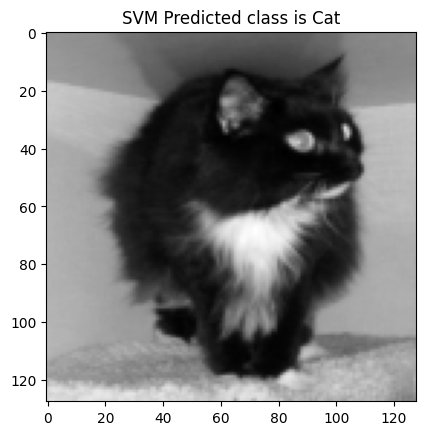

In [9]:
# Use the same image to predict with SVM
processed_image_svm = processed_image_cnn[0].reshape(1, -1)  # Flatten the image for SVM
predicted_svm = clf.predict(processed_image_svm)[0]
predicted_class_svm = 'Cat' if predicted_svm == 1 else 'Dog'

# Display the image and prediction result for SVM
plt.imshow(processed_image_cnn[0].reshape(128, 128), cmap='gray')
plt.title(f'SVM Predicted class is {predicted_class_svm}')
plt.show()
